In [9]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['retina']
plt.rc('font', size=12)
plt.style.use('seaborn-darkgrid')

In [3]:
# 1. load the stock returns data.
series = pd.read_csv('stock_returns.csv')
returns = series.values[:1000]

In [4]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 1 columns):
0    19998 non-null float64
dtypes: float64(1)
memory usage: 156.3 KB


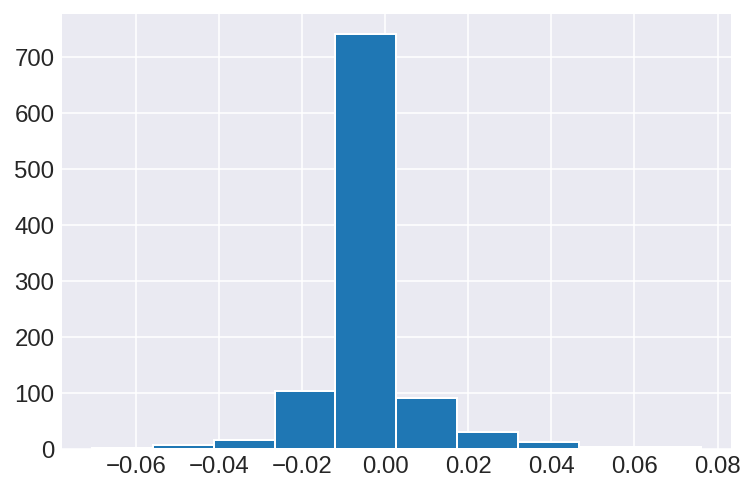

In [27]:
plt.hist(returns, ec='white');

In [5]:
# 2. first, let's see if it makes sense to fit a Gaussian distribution to this.
with pm.Model() as model1:

    stdev = pm.HalfNormal('stdev', sd=.1)
    mu = pm.Normal('mu', mu=0.0, sd=1.)

    pm.Normal('returns', mu=mu, sd=stdev, observed=returns)

In [6]:
with model1:
    trace = pm.sample(500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, stdev]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2119.80draws/s]


In [7]:
preds = pm.sample_ppc(trace, samples=500, model=model1)
y = np.reshape(np.mean(preds['returns'], axis=0), [-1])

100%|██████████| 500/500 [00:00<00:00, 1632.68it/s]


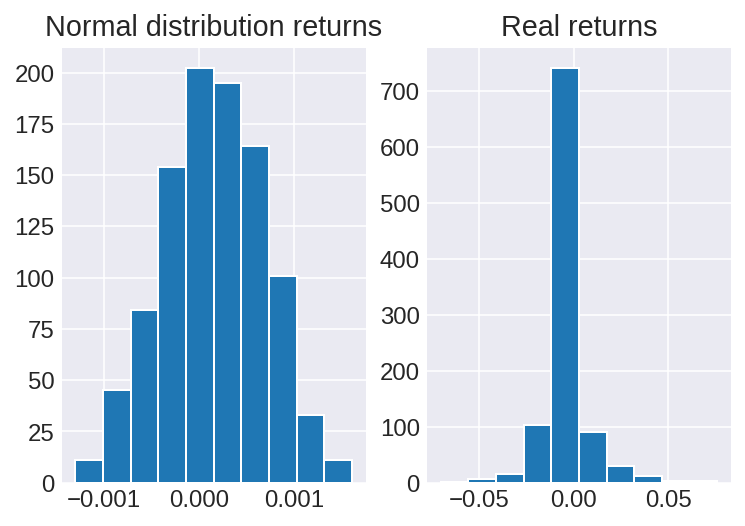

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(y, ec='white')
ax1.set_title('Normal distribution returns')
ax2.hist(returns, ec='white')
ax2.set_title('Real returns')

plt.show()

In [11]:
# 3. now let's relax the normal distribution assumption: let's fit a Cauchy distribution.
with pm.Model() as model2:

    beta = pm.HalfNormal('beta', sd=10.)

    pm.Cauchy('returns', alpha=0.0, beta=beta, observed=returns)

    mean_field = pm.fit(n=150000, method='advi', obj_optimizer=pm.adam(learning_rate=.001))

Average Loss = -66,904: 100%|██████████| 150000/150000 [01:02<00:00, 2395.48it/s]
Finished [100%]: Average Loss = -66,910


In [28]:
with model2:
    trace2 = mean_field.sample(draws=10000)
    trace3 = pm.sample(5000, tune=10000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:42<00:00, 1401.83draws/s]
There were 2562 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2519 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8826667027142162, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2570 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2532 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


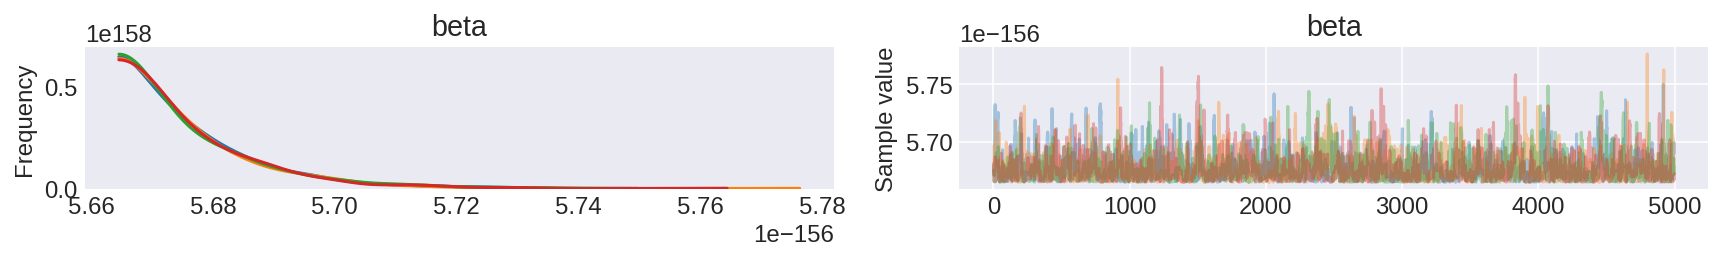

In [33]:
pm.traceplot(trace3);

In [34]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,5.676737e-156,1.203023e-158,3.003518e-160,5.664563e-156,5.700435e-156,1452.464918,1.000297


In [39]:
# change to trace3 if you want
preds2 = pm.sample_ppc(trace3, samples=10000, model=model2)
y2 = np.reshape(np.mean(preds2['returns'], axis=0), [-1])

100%|██████████| 10000/10000 [00:03<00:00, 2982.33it/s]


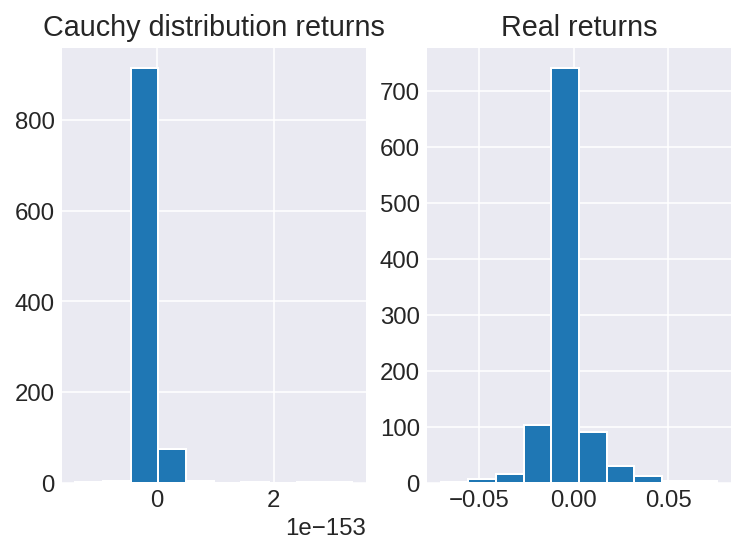

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(y2, ec='white')
ax1.set_title('Cauchy distribution returns')
ax2.hist(returns, ec='white')
ax2.set_title('Real returns')

plt.show()

In [41]:
model1.name = 'Gaussian model'
model2.name = 'Cauchy model'
df_LOO = pm.compare({model1:trace, model2:trace2}, ic='LOO')

In [42]:
print("LOO comparison table: ")
df_LOO

LOO comparison table: 


,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
Cauchy model,-133738,814.36,0,0.73,8074.07,0,0
Gaussian model,-6110.4,5.8,127628,0.27,105.21,8022.75,0
